In [2]:
import pandas as pd

# Cargar el dataframe limpio desde el archivo pickle
df = pd.read_pickle('data_limpia.pkl')

# Ver las primeras filas para confirmar que se cargó correctamente
print(df.head())
print(f"Dimensiones del dataset: {df.shape}")
print(f"Columnas: {df.columns.tolist()}")

    age  monthly_inhand_salary  num_bank_accounts  num_credit_card  \
0  23.0            1824.843333                3.0              4.0   
1  23.0            1426.204829                3.0              4.0   
2  40.8            2059.822083                3.0              4.0   
3  23.0            1661.386500                3.0              4.0   
4  23.0            1824.843333                3.0              4.0   

   interest_rate  delay_from_due_date  num_of_delayed_payment  \
0            3.0                    3                     7.0   
1            3.0                   -1                     7.6   
2            3.0                    3                     7.0   
3            3.0                    5                     4.0   
4            3.0                    6                     8.6   

   changed_credit_limit  num_credit_inquiries  outstanding_debt  ...  \
0                 11.27                   4.0            809.98  ...   
1                 11.27                   4.

In [4]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
X = df.drop('credit_score', axis=1)
y = df['credit_score']

# Codificar variables categóricas
X_encoded = X.copy()
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col].astype(str))

# Codificar target
le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [7]:
y

0            Good
1            Good
2            Good
3            Good
4            Good
           ...   
99995        Poor
99996        Poor
99997        Poor
99998    Standard
99999        Poor
Name: credit_score, Length: 100000, dtype: object

In [ ]:
y_encoded

array([0, 0, 0, ..., 1, 2, 1])

## SMOTE + ADASYN

🔄 INICIANDO BALANCEO COMPLETO DE CLASES...
📊 DISTRIBUCIÓN DE CLASES ORIGINAL:
  Standard: 37222 muestras (53.2%)
  Poor: 20299 muestras (29.0%)
  Good: 12479 muestras (17.8%)

🔄 APLICANDO SMOTE...
📊 DISTRIBUCIÓN DE CLASES CON SMOTE:
  Standard: 37222 muestras (33.3%)
  Poor: 37222 muestras (33.3%)
  Good: 37222 muestras (33.3%)

🔄 APLICANDO ADASYN...
📊 DISTRIBUCIÓN DE CLASES CON ADASYN:
  Standard: 37222 muestras (31.4%)
  Poor: 41494 muestras (35.0%)
  Good: 39678 muestras (33.5%)

💾 Todos los datos balanceados guardados: 'balanced_data_complete.pkl'


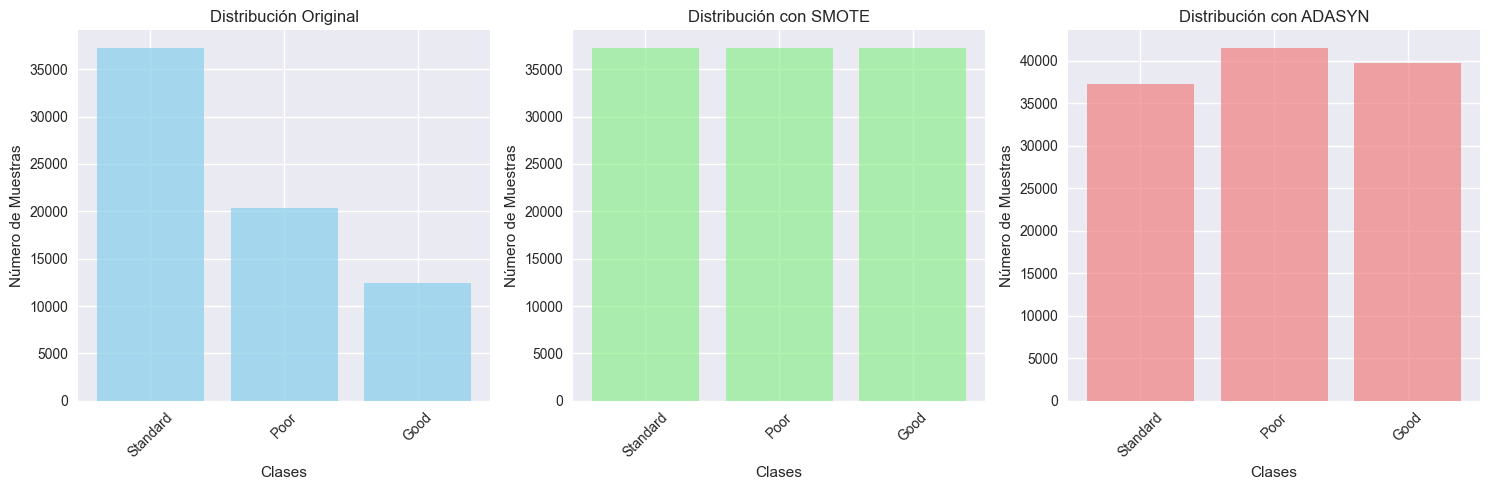

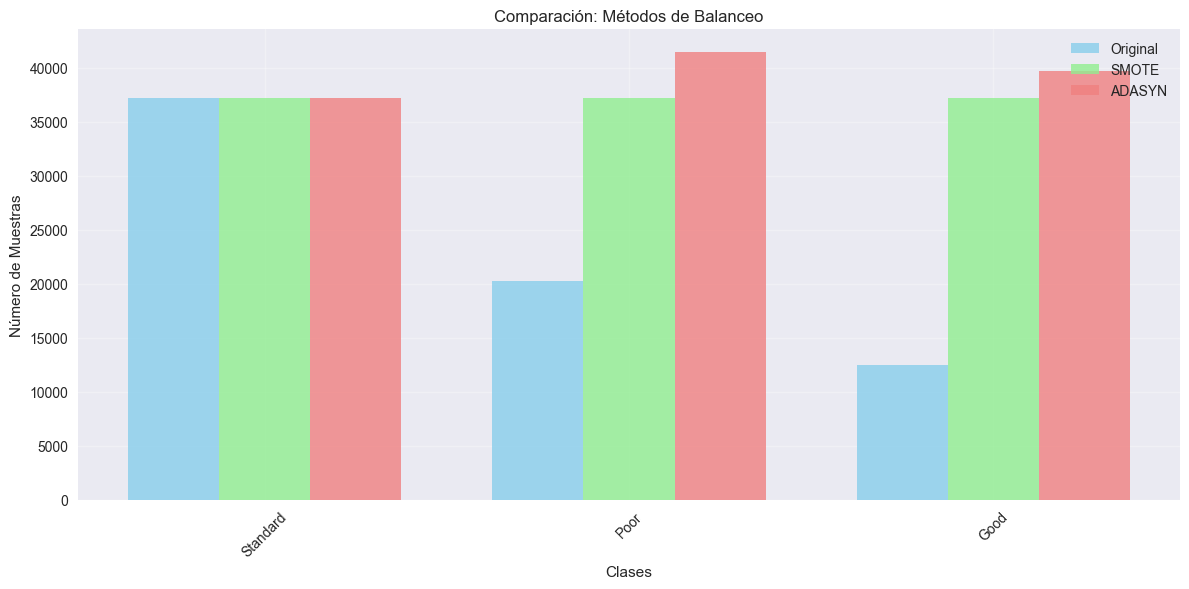


🎯 RESUMEN COMPLETO - BALANCEO DE CLASES
⏱️  Tiempo de ejecución: 6.75s

📊 ESTADÍSTICAS DEL DATASET:
  Muestras originales train: 70000
  Muestras con SMOTE: 111666
  Muestras con ADASYN: 118394
  Muestras test: 30000
  Características: 48
  Clases: 3

📈 INCREMENTO POR MÉTODO:
  SMOTE: +41666 muestras
  ADASYN: +48394 muestras

🔍 DIFERENCIAS ENTRE MÉTODOS:
  Standard:
    Original: 37222 | SMOTE: 37222 (+0) | ADASYN: 37222 (+0)
  Poor:
    Original: 20299 | SMOTE: 37222 (+16923) | ADASYN: 41494 (+21195)
  Good:
    Original: 12479 | SMOTE: 37222 (+24743) | ADASYN: 39678 (+27199)

💾 ARCHIVO GENERADO:
  'balanced_data_complete.pkl' - Contiene todos los conjuntos de datos balanceados

✅ USO EN MODELOS:
  from balanced_data_complete.pkl import:
    - X_train_smote, y_train_smote para entrenar con SMOTE
    - X_train_adasyn, y_train_adasyn para entrenar con ADASYN
    - X_train_original, y_train_original para comparación


In [4]:
# BALANCEO DE CLASES COMPLETO - SMOTE + ADASYN
# =============================================================================

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
from collections import Counter

print("🔄 INICIANDO BALANCEO COMPLETO DE CLASES...")
start_time = time.time()

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# =============================================================================
# PREPROCESAMIENTO
# =============================================================================

# Cargar datos
df = pd.read_pickle('data_limpia.pkl')

# Separar características y target
X = df.drop('credit_score', axis=1)
y = df['credit_score']

# Split de datos ANTES de la codificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Identificar columnas categóricas y numéricas
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=[np.number]).columns

# Crear el preprocesador con OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ]
)

# Aplicar transformaciones
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Codificar target
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print("📊 DISTRIBUCIÓN DE CLASES ORIGINAL:")
class_dist_original = Counter(y_train_encoded)
for class_idx, count in class_dist_original.items():
    class_name = le.classes_[class_idx]
    percentage = (count / len(y_train_encoded)) * 100
    print(f"  {class_name}: {count} muestras ({percentage:.1f}%)")

# =============================================================================
# APLICAR SMOTE
# =============================================================================

print("\n🔄 APLICANDO SMOTE...")

try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    print("❌ Instalando imbalanced-learn...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "imbalanced-learn"])
    from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train_encoded)

print("📊 DISTRIBUCIÓN DE CLASES CON SMOTE:")
class_dist_smote = Counter(y_train_smote)
for class_idx, count in class_dist_smote.items():
    class_name = le.classes_[class_idx]
    percentage = (count / len(y_train_smote)) * 100
    print(f"  {class_name}: {count} muestras ({percentage:.1f}%)")

# =============================================================================
# APLICAR ADASYN
# =============================================================================

print("\n🔄 APLICANDO ADASYN...")

from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_processed, y_train_encoded)

print("📊 DISTRIBUCIÓN DE CLASES CON ADASYN:")
class_dist_adasyn = Counter(y_train_adasyn)
for class_idx, count in class_dist_adasyn.items():
    class_name = le.classes_[class_idx]
    percentage = (count / len(y_train_adasyn)) * 100
    print(f"  {class_name}: {count} muestras ({percentage:.1f}%)")

# =============================================================================
# GUARDAR DATOS BALANCEADOS EN UN SOLO ARCHIVO
# =============================================================================

balanced_data = {
    # Datos originales (para referencia)
    'X_train_original': X_train_processed,
    'y_train_original': y_train_encoded,
    
    # Datos con SMOTE
    'X_train_smote': X_train_smote,
    'y_train_smote': y_train_smote,
    
    # Datos con ADASYN
    'X_train_adasyn': X_train_adasyn,
    'y_train_adasyn': y_train_adasyn,
    
    # Datos de test (comunes para todos)
    'X_test_processed': X_test_processed,
    'y_test_encoded': y_test_encoded,
    
    # Preprocesadores y codificadores
    'preprocessor': preprocessor,
    'label_encoder': le,
    
    # Distribuciones
    'class_dist_original': class_dist_original,
    'class_dist_smote': class_dist_smote,
    'class_dist_adasyn': class_dist_adasyn,
    
    # Nombres de características
    'feature_names': (list(numerical_cols) + 
                     list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))),
    
    # Información del dataset
    'dataset_info': {
        'original_samples': X_train_processed.shape[0],
        'smote_samples': X_train_smote.shape[0],
        'adasyn_samples': X_train_adasyn.shape[0],
        'test_samples': X_test_processed.shape[0],
        'n_features': X_train_processed.shape[1],
        'n_classes': len(le.classes_)
    }
}

joblib.dump(balanced_data, 'balanced_data_complete.pkl')

print(f"\n💾 Todos los datos balanceados guardados: 'balanced_data_complete.pkl'")

# =============================================================================
# VISUALIZACIÓN COMPARATIVA
# =============================================================================

plt.figure(figsize=(15, 5))

# Gráfico 1: Distribución original
plt.subplot(1, 3, 1)
classes_orig = [le.classes_[idx] for idx in class_dist_original.keys()]
counts_orig = list(class_dist_original.values())
plt.bar(classes_orig, counts_orig, color='skyblue', alpha=0.7)
plt.title('Distribución Original')
plt.xlabel('Clases')
plt.ylabel('Número de Muestras')
plt.xticks(rotation=45)

# Gráfico 2: Distribución con SMOTE
plt.subplot(1, 3, 2)
classes_smote = [le.classes_[idx] for idx in class_dist_smote.keys()]
counts_smote = list(class_dist_smote.values())
plt.bar(classes_smote, counts_smote, color='lightgreen', alpha=0.7)
plt.title('Distribución con SMOTE')
plt.xlabel('Clases')
plt.ylabel('Número de Muestras')
plt.xticks(rotation=45)

# Gráfico 3: Distribución con ADASYN
plt.subplot(1, 3, 3)
classes_adasyn = [le.classes_[idx] for idx in class_dist_adasyn.keys()]
counts_adasyn = list(class_dist_adasyn.values())
plt.bar(classes_adasyn, counts_adasyn, color='lightcoral', alpha=0.7)
plt.title('Distribución con ADASYN')
plt.xlabel('Clases')
plt.ylabel('Número de Muestras')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# =============================================================================
# RESUMEN COMPARATIVO
# =============================================================================

plt.figure(figsize=(12, 6))

# Comparación lado a lado
x_pos = np.arange(len(classes_orig))
width = 0.25

plt.bar(x_pos - width, counts_orig, width, label='Original', alpha=0.8, color='skyblue')
plt.bar(x_pos, counts_smote, width, label='SMOTE', alpha=0.8, color='lightgreen')
plt.bar(x_pos + width, counts_adasyn[:len(classes_orig)], width, label='ADASYN', alpha=0.8, color='lightcoral')

plt.xlabel('Clases')
plt.ylabel('Número de Muestras')
plt.title('Comparación: Métodos de Balanceo')
plt.xticks(x_pos, classes_orig, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# RESUMEN FINAL
# =============================================================================

end_time = time.time()
execution_time = end_time - start_time

print("\n" + "="*70)
print("🎯 RESUMEN COMPLETO - BALANCEO DE CLASES")
print("="*70)

print(f"⏱️  Tiempo de ejecución: {execution_time:.2f}s")

print(f"\n📊 ESTADÍSTICAS DEL DATASET:")
print(f"  Muestras originales train: {X_train_processed.shape[0]}")
print(f"  Muestras con SMOTE: {X_train_smote.shape[0]}")
print(f"  Muestras con ADASYN: {X_train_adasyn.shape[0]}")
print(f"  Muestras test: {X_test_processed.shape[0]}")
print(f"  Características: {X_train_processed.shape[1]}")
print(f"  Clases: {len(le.classes_)}")

print(f"\n📈 INCREMENTO POR MÉTODO:")
print(f"  SMOTE: +{X_train_smote.shape[0] - X_train_processed.shape[0]} muestras")
print(f"  ADASYN: +{X_train_adasyn.shape[0] - X_train_processed.shape[0]} muestras")

print(f"\n🔍 DIFERENCIAS ENTRE MÉTODOS:")
for class_idx in class_dist_original.keys():
    class_name = le.classes_[class_idx]
    orig = class_dist_original[class_idx]
    smote = class_dist_smote[class_idx]
    adasyn = class_dist_adasyn[class_idx]
    
    print(f"  {class_name}:")
    print(f"    Original: {orig} | SMOTE: {smote} (+{smote-orig}) | ADASYN: {adasyn} (+{adasyn-orig})")

print(f"\n💾 ARCHIVO GENERADO:")
print(f"  'balanced_data_complete.pkl' - Contiene todos los conjuntos de datos balanceados")

print(f"\n✅ USO EN MODELOS:")
print(f"  from balanced_data_complete.pkl import:")
print(f"    - X_train_smote, y_train_smote para entrenar con SMOTE")
print(f"    - X_train_adasyn, y_train_adasyn para entrenar con ADASYN")
print(f"    - X_train_original, y_train_original para comparación")

print("="*70)

## K-Nearest Neighbors (KNN) Classifier

🚀 INICIANDO KNN - COMPARACIÓN CON Y SIN BALANCEO...

🎯 ENTRENANDO KNN CON DATOS ORIGINALES...
📊 MÉTRICAS KNN (DATOS ORIGINALES):
Accuracy: 0.7483
Precision: 0.7508
Recall: 0.7483
F1-Score: 0.7492
CV Mean: 0.7351
CV Std: 0.0031

📋 REPORTE DE CLASIFICACIÓN (DATOS ORIGINALES):
              precision    recall  f1-score   support

        Good       0.64      0.68      0.66      5349
        Poor       0.74      0.77      0.76      8699
    Standard       0.79      0.76      0.78     15952

    accuracy                           0.75     30000
   macro avg       0.72      0.74      0.73     30000
weighted avg       0.75      0.75      0.75     30000


📊 TABLA DE MÉTRICAS POR CLASE (DATOS ORIGINALES):
             precision  recall     f1-score   support   
------------------------------------------------------------
Good         0.64       0.68       0.66       5349.0    
Poor         0.74       0.77       0.76       8699.0    
Standard     0.79       0.76       0.78       15952.0   
macr

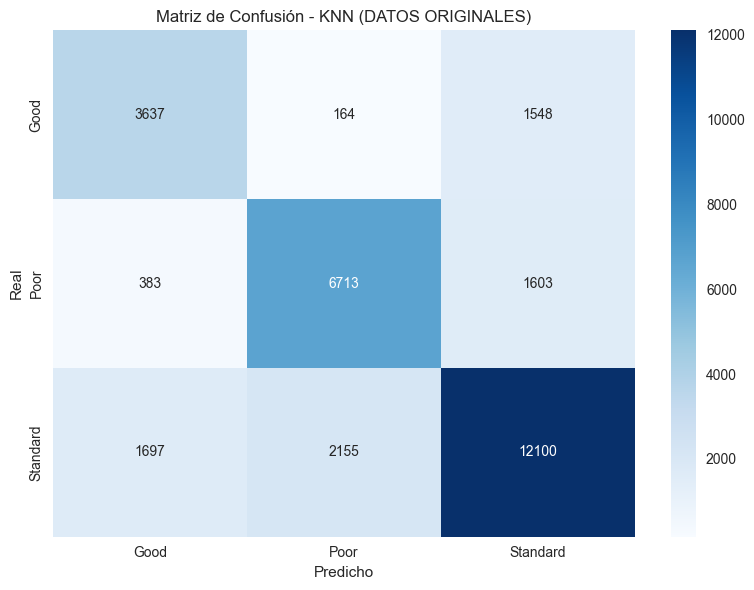


🎯 ENTRENANDO KNN CON SMOTE...
📊 MÉTRICAS KNN (SMOTE):
Accuracy: 0.7255
Precision: 0.7686
Recall: 0.7255
F1-Score: 0.7270
CV Mean: 0.8296
CV Std: 0.0166

📋 REPORTE DE CLASIFICACIÓN (SMOTE):
              precision    recall  f1-score   support

        Good       0.55      0.86      0.67      5349
        Poor       0.71      0.85      0.77      8699
    Standard       0.88      0.62      0.72     15952

    accuracy                           0.73     30000
   macro avg       0.71      0.77      0.72     30000
weighted avg       0.77      0.73      0.73     30000


📊 TABLA DE MÉTRICAS POR CLASE (SMOTE):
             precision  recall     f1-score   support   
------------------------------------------------------------
Good         0.55       0.86       0.67       5349.0    
Poor         0.71       0.85       0.77       8699.0    
Standard     0.88       0.62       0.72       15952.0   
macro avg    0.71       0.77       0.72       30000.0   
weighted avg 0.77       0.73       0.73    

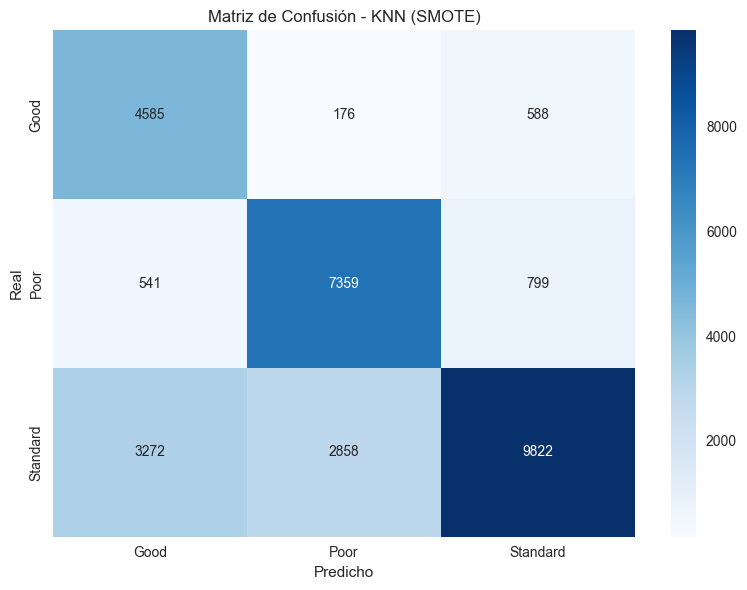


🎯 ENTRENANDO KNN CON ADASYN...
📊 MÉTRICAS KNN (ADASYN):
Accuracy: 0.7111
Precision: 0.7720
Recall: 0.7111
F1-Score: 0.7092
CV Mean: 0.8288
CV Std: 0.0070

📋 REPORTE DE CLASIFICACIÓN (ADASYN):
              precision    recall  f1-score   support

        Good       0.54      0.87      0.66      5349
        Poor       0.68      0.89      0.77      8699
    Standard       0.90      0.56      0.69     15952

    accuracy                           0.71     30000
   macro avg       0.71      0.77      0.71     30000
weighted avg       0.77      0.71      0.71     30000


📊 TABLA DE MÉTRICAS POR CLASE (ADASYN):
             precision  recall     f1-score   support   
------------------------------------------------------------
Good         0.54       0.87       0.66       5349.0    
Poor         0.68       0.89       0.77       8699.0    
Standard     0.90       0.56       0.69       15952.0   
macro avg    0.71       0.77       0.71       30000.0   
weighted avg 0.77       0.71       0.71

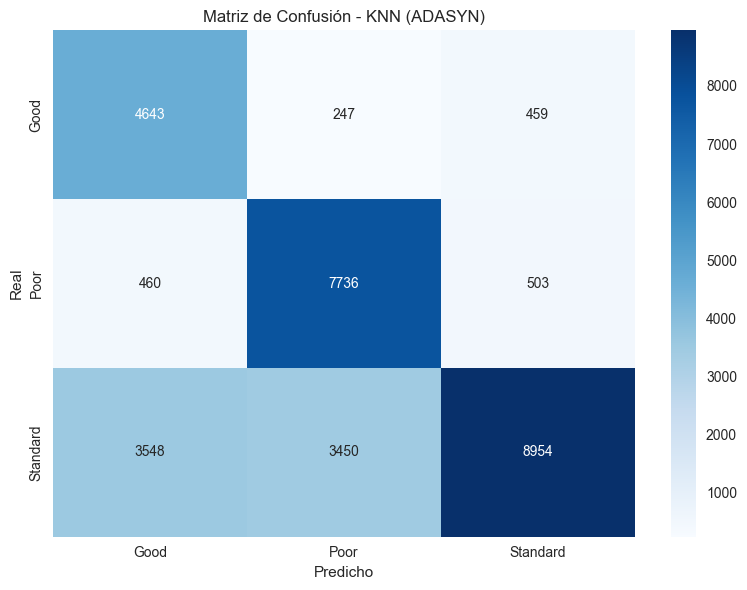


📊 COMPARACIÓN COMPLETA - KNN CON DIFERENTES BALANCEOS

📈 COMPARACIÓN DE MÉTRICAS:
     Método  Accuracy  Precision  Recall  F1-Score  CV_Mean  CV_Std  \
0  ORIGINAL    0.7483     0.7508  0.7483    0.7492   0.7351  0.0031   
1     SMOTE    0.7255     0.7686  0.7255    0.7270   0.8296  0.0166   
2    ADASYN    0.7111     0.7720  0.7111    0.7092   0.8288  0.0070   

   Tiempo (s)  
0      8.4857  
1     18.2661  
2     21.1943  


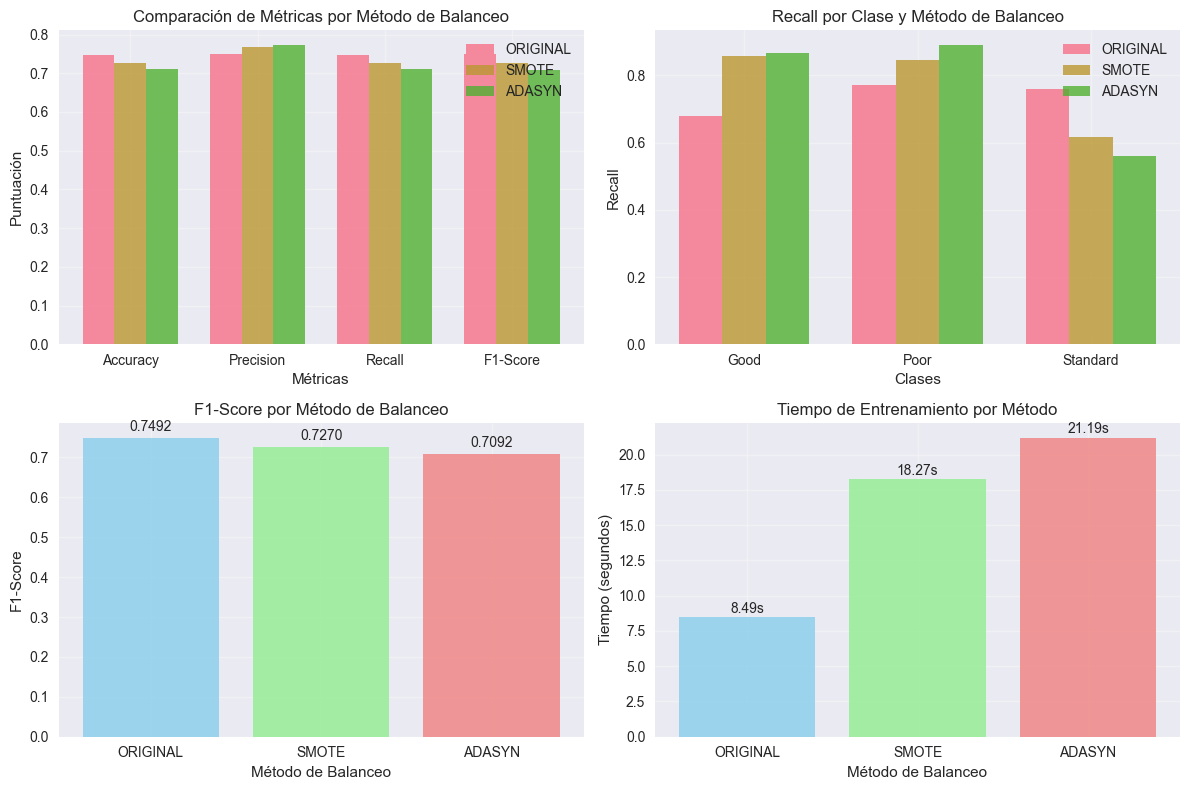


🔍 ANÁLISIS DE MEJORAS CON BALANCEO:
📈 MEJORA EN RECALL:
   SMOTE vs Original: -0.0228
   ADASYN vs Original: -0.0372

📈 MEJORA EN F1-SCORE:
   SMOTE vs Original: -0.0221
   ADASYN vs Original: -0.0399

🎯 RESUMEN FINAL - KNN CON BALANCEO
⏱️  Tiempo total de ejecución: 49.00s

🏆 MEJORES RESULTADOS:
   Accuracy: ORIGINAL (0.7483)
   Recall: ORIGINAL (0.7483)
   F1-Score: ORIGINAL (0.7492)

📊 RECOMENDACIÓN:
   ℹ️  Los datos originales funcionan mejor para este modelo


In [7]:
# =============================================================================
# KNN - COMPARACIÓN CON Y SIN BALANCEO
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Configuración
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 INICIANDO KNN - COMPARACIÓN CON Y SIN BALANCEO...")
start_time = time.time()

# Cargar datos balanceados
balanced_data = joblib.load('balanced_data_complete.pkl')

# =============================================================================
# FUNCIÓN PARA ENTRENAR Y EVALUAR KNN
# =============================================================================

def entrenar_evaluar_knn(X_train, y_train, X_test, y_test, nombre_conjunto):
    print(f"\n🎯 ENTRENANDO KNN CON {nombre_conjunto}...")
    model_start = time.time()
    
    knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
    knn_model.fit(X_train, y_train)
    
    # Predicciones
    y_pred = knn_model.predict(X_test)
    
    # Métricas principales
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Validación cruzada
    cv_scores = cross_val_score(knn_model, X_train, y_train, cv=5, scoring='accuracy')
    
    model_time = time.time() - model_start
    
    print(f"📊 MÉTRICAS KNN ({nombre_conjunto}):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"CV Mean: {cv_scores.mean():.4f}")
    print(f"CV Std: {cv_scores.std():.4f}")
    
    # Reporte de clasificación
    print(f"\n📋 REPORTE DE CLASIFICACIÓN ({nombre_conjunto}):")
    le = balanced_data['label_encoder']
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Tabla de métricas por clase
    from sklearn.metrics import precision_recall_fscore_support
    
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_test, y_pred, labels=[0, 1, 2]
    )
    
    class_report_df = pd.DataFrame({
        'precision': precision_per_class,
        'recall': recall_per_class,
        'f1-score': f1_per_class,
        'support': support_per_class
    }, index=le.classes_)
    
    # Calcular promedios
    macro_avg = class_report_df[['precision', 'recall', 'f1-score']].mean()
    weighted_avg = np.average(class_report_df[['precision', 'recall', 'f1-score']], 
                             weights=class_report_df['support'], axis=0)
    
    # Agregar filas de promedios
    class_report_df.loc['macro avg'] = [macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], class_report_df['support'].sum()]
    class_report_df.loc['weighted avg'] = [weighted_avg[0], weighted_avg[1], weighted_avg[2], class_report_df['support'].sum()]
    class_report_df.loc['accuracy'] = [accuracy, '', '', class_report_df['support'].sum()]
    
    print(f"\n📊 TABLA DE MÉTRICAS POR CLASE ({nombre_conjunto}):")
    print("="*60)
    print(f"{'':<12} {'precision':<10} {'recall':<10} {'f1-score':<10} {'support':<10}")
    print("-" * 60)
    for idx, row in class_report_df.iterrows():
        if idx == 'accuracy':
            print(f"{idx:<12} {'':<10} {'':<10} {'':<10} {row['support']:<10}")
            print(f"{'':<12} {'':<10} {'':<10} {row['precision']:<10.2f} {'':<10}")
        else:
            print(f"{idx:<12} {row['precision']:<10.2f} {row['recall']:<10.2f} {row['f1-score']:<10.2f} {row['support']:<10}")
    print("="*60)
    
    # Matriz de confusión
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Matriz de Confusión - KNN ({nombre_conjunto})')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.tight_layout()
    plt.show()
    
    return {
        'model': knn_model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'execution_time': model_time,
        'classification_report': class_report_df,
        'y_pred': y_pred
    }

# =============================================================================
# ENTRENAR CON DIFERENTES CONJUNTOS DE DATOS
# =============================================================================

# Obtener datos de test (comunes para todos)
X_test = balanced_data['X_test_processed']
y_test = balanced_data['y_test_encoded']
le = balanced_data['label_encoder']

resultados = {}

# 1. Con datos originales (sin balanceo)
resultados['original'] = entrenar_evaluar_knn(
    balanced_data['X_train_original'],
    balanced_data['y_train_original'],
    X_test, y_test,
    'DATOS ORIGINALES'
)

# 2. Con datos balanceados con SMOTE
resultados['smote'] = entrenar_evaluar_knn(
    balanced_data['X_train_smote'],
    balanced_data['y_train_smote'],
    X_test, y_test,
    'SMOTE'
)

# 3. Con datos balanceados con ADASYN
resultados['adasyn'] = entrenar_evaluar_knn(
    balanced_data['X_train_adasyn'],
    balanced_data['y_train_adasyn'],
    X_test, y_test,
    'ADASYN'
)

# =============================================================================
# COMPARACIÓN DE RESULTADOS
# =============================================================================

print("\n" + "="*80)
print("📊 COMPARACIÓN COMPLETA - KNN CON DIFERENTES BALANCEOS")
print("="*80)

comparison_data = []
for metodo, resultado in resultados.items():
    comparison_data.append({
        'Método': metodo.upper(),
        'Accuracy': resultado['accuracy'],
        'Precision': resultado['precision'],
        'Recall': resultado['recall'],
        'F1-Score': resultado['f1'],
        'CV_Mean': resultado['cv_mean'],
        'CV_Std': resultado['cv_std'],
        'Tiempo (s)': resultado['execution_time']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n📈 COMPARACIÓN DE MÉTRICAS:")
print(comparison_df.round(4))

# Gráfico comparativo
plt.figure(figsize=(12, 8))

# Gráfico 1: Métricas principales
plt.subplot(2, 2, 1)
metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x_pos = np.arange(len(metricas))
width = 0.25

for i, metodo in enumerate(['original', 'smote', 'adasyn']):
    valores = [
        resultados[metodo]['accuracy'],
        resultados[metodo]['precision'],
        resultados[metodo]['recall'],
        resultados[metodo]['f1']
    ]
    plt.bar(x_pos + i*width, valores, width, label=metodo.upper(), alpha=0.8)

plt.xlabel('Métricas')
plt.ylabel('Puntuación')
plt.title('Comparación de Métricas por Método de Balanceo')
plt.xticks(x_pos + width, metricas)
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 2: Recall por clase para cada método
plt.subplot(2, 2, 2)
clases = le.classes_
x_pos = np.arange(len(clases))
width = 0.25

for i, metodo in enumerate(['original', 'smote', 'adasyn']):
    recall_clases = resultados[metodo]['classification_report'].loc[clases]['recall'].values
    plt.bar(x_pos + i*width, recall_clases, width, label=metodo.upper(), alpha=0.8)

plt.xlabel('Clases')
plt.ylabel('Recall')
plt.title('Recall por Clase y Método de Balanceo')
plt.xticks(x_pos + width, clases)
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 3: Comparación de F1-Score
plt.subplot(2, 2, 3)
metodos = ['ORIGINAL', 'SMOTE', 'ADASYN']
f1_scores = [resultados[metodo.lower()]['f1'] for metodo in metodos]
colors = ['skyblue', 'lightgreen', 'lightcoral']

plt.bar(metodos, f1_scores, color=colors, alpha=0.8)
plt.xlabel('Método de Balanceo')
plt.ylabel('F1-Score')
plt.title('F1-Score por Método de Balanceo')
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

# Gráfico 4: Tiempos de ejecución
plt.subplot(2, 2, 4)
tiempos = [resultados[metodo.lower()]['execution_time'] for metodo in metodos]

plt.bar(metodos, tiempos, color=colors, alpha=0.8)
plt.xlabel('Método de Balanceo')
plt.ylabel('Tiempo (segundos)')
plt.title('Tiempo de Entrenamiento por Método')
for i, v in enumerate(tiempos):
    plt.text(i, v + 0.1, f'{v:.2f}s', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# ANÁLISIS DE MEJORAS
# =============================================================================

print("\n🔍 ANÁLISIS DE MEJORAS CON BALANCEO:")

original_recall = resultados['original']['recall']
smote_recall = resultados['smote']['recall']
adasyn_recall = resultados['adasyn']['recall']

original_f1 = resultados['original']['f1']
smote_f1 = resultados['smote']['f1']
adasyn_f1 = resultados['adasyn']['f1']

print(f"📈 MEJORA EN RECALL:")
print(f"   SMOTE vs Original: {smote_recall - original_recall:+.4f}")
print(f"   ADASYN vs Original: {adasyn_recall - original_recall:+.4f}")

print(f"\n📈 MEJORA EN F1-SCORE:")
print(f"   SMOTE vs Original: {smote_f1 - original_f1:+.4f}")
print(f"   ADASYN vs Original: {adasyn_f1 - original_f1:+.4f}")

# =============================================================================
# RESUMEN FINAL
# =============================================================================

end_time = time.time()
execution_time_total = end_time - start_time

print("\n" + "="*80)
print("🎯 RESUMEN FINAL - KNN CON BALANCEO")
print("="*80)

print(f"⏱️  Tiempo total de ejecución: {execution_time_total:.2f}s")

# Encontrar mejor método por métrica
mejor_accuracy = max(resultados.items(), key=lambda x: x[1]['accuracy'])
mejor_recall = max(resultados.items(), key=lambda x: x[1]['recall'])
mejor_f1 = max(resultados.items(), key=lambda x: x[1]['f1'])

print(f"\n🏆 MEJORES RESULTADOS:")
print(f"   Accuracy: {mejor_accuracy[0].upper()} ({mejor_accuracy[1]['accuracy']:.4f})")
print(f"   Recall: {mejor_recall[0].upper()} ({mejor_recall[1]['recall']:.4f})")
print(f"   F1-Score: {mejor_f1[0].upper()} ({mejor_f1[1]['f1']:.4f})")

print(f"\n📊 RECOMENDACIÓN:")
if mejor_f1[0] != 'original':
    print(f"   ✅ Se recomienda usar {mejor_f1[0].upper()} para mejor balance precisión-recall")
else:
    print("   ℹ️  Los datos originales funcionan mejor para este modelo")

print("="*80)

## Naive Bayes

🚀 INICIANDO NAIVE BAYES - MODELO BENCHMARK...
✅ Datos preparados: 70000 train, 30000 test

🎯 ENTRENANDO MODELO 

📈 EVALUANDO MODELO BAYESIANO...

📋 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

        Good       0.46      0.84      0.60      5349
        Poor       0.62      0.71      0.66      8699
    Standard       0.83      0.54      0.65     15952

    accuracy                           0.64     30000
   macro avg       0.64      0.70      0.64     30000
weighted avg       0.70      0.64      0.64     30000



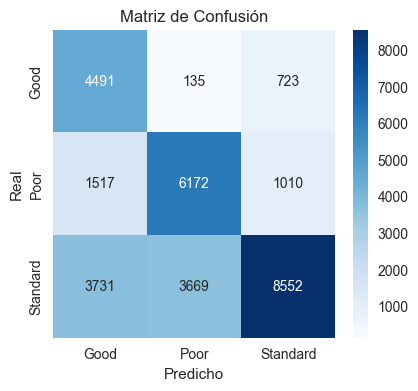


🔍 ANÁLISIS DE ERRORES POR CLASE:
Accuracy por clase:
  Good: 0.8396 (83.96%)
  Poor: 0.7095 (70.95%)
  Standard: 0.5361 (53.61%)

🎯 RESUMEN FINAL - NAIVE BAYES BENCHMARK
⏱️  Tiempo ejecución: 0.63s

🎯 EVALUACIÓN: ⚠️  ACEPTABLE

💾 Resultados guardados: 'bayes_benchmark_results.pkl'


In [2]:
# =============================================================================
# Naive Bayes - MODELO BENCHMARK
# =============================================================================

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Configuración
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 INICIANDO NAIVE BAYES - MODELO BENCHMARK...")
start_time = time.time()

# =============================================================================
# PREPROCESAMIENTO
# =============================================================================


# Separar características y target
X = df.drop('credit_score', axis=1)
y = df['credit_score']

y = y.map({
    'Good': 0,
    'Poor': 1,
    'Standard': 2
    
})


# Seleccionamos las variables numericas a estandarizar
num_cols=['age', 'monthly_inhand_salary',
          'num_bank_accounts', 'num_credit_card', 'interest_rate',
          'delay_from_due_date', 'num_of_delayed_payment','changed_credit_limit',
          'num_credit_inquiries', 'outstanding_debt', 'credit_utilization_ratio',
          'credit_history_age','total_emi_per_month', 'amount_invested_monthly',
          'monthly_balance']

# Seleccionamos las variables categóricas a codificar
cat_cols=['occupation', 'credit_mix', 'payment_of_min_amount','payment_behaviour']
# Se no se toman las variables binarias ya que estas ya pueden considerarse
# como codificadas


# Split de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Codificación de categóricas
ohe = OneHotEncoder(drop="first", handle_unknown="ignore", sparse=False)

X_train_cat = ohe.fit_transform(X_train[cat_cols])
X_test_cat = ohe.transform(X_test[cat_cols])

# Estandarización de numéricas
scaler = StandardScaler()

X_train_num = scaler.fit_transform(X_train[num_cols])
X_test_num = scaler.transform(X_test[num_cols])

# Combinar numéricas y categóricas
X_train_final = np.hstack([X_train_num, X_train_cat])
X_test_final = np.hstack([X_test_num, X_test_cat])



print(f"✅ Datos preparados: {X_train_final.shape[0]} train, {X_test_final.shape[0]} test")

# =============================================================================
# ENTRENAMIENTO DEL MODELO 
# =============================================================================

print(f"\n🎯 ENTRENANDO MODELO ")

bayes=GaussianNB()
bayes.fit(X_train_final,y_train)

# Predicciones
y_pred = bayes.predict(X_test_final)


# =============================================================================
# EVALUACIÓN COMPLETA
# =============================================================================

print("\n📈 EVALUANDO MODELO BAYESIANO...")

# Métricas principales
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Reporte de clasificación
print("\n📋 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test, y_pred, target_names=['Good', 'Poor', 'Standard']))

# =============================================================================
# VISUALIZACIONES 
# =============================================================================

# 1. Matriz de confusión
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Good', 'Poor', 'Standard'], yticklabels=['Good', 'Poor', 'Standard'])
plt.title(f'Matriz de Confusión')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

# =============================================================================
# ANÁLISIS DE ERRORES POR CLASE
# =============================================================================

print("\n🔍 ANÁLISIS DE ERRORES POR CLASE:")

# Calcular accuracy por clase
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
class_accuracy = cm.diagonal() / cm.sum(axis=1)

print("Accuracy por clase:")
for i, cls in enumerate(['Good', 'Poor', 'Standard']):
    print(f"  {cls}: {class_accuracy[i]:.4f} ({class_accuracy[i]*100:.2f}%)")

# =============================================================================
# RESUMEN FINAL
# =============================================================================

end_time = time.time()
execution_time = end_time - start_time


print("\n" + "="*60)
print("🎯 RESUMEN FINAL - NAIVE BAYES BENCHMARK")
print("="*60)
print(f"⏱️  Tiempo ejecución: {execution_time:.2f}s")

# Evaluación cualitativa
if f1 > 0.8:
    performance = "🌟 EXCELENTE"
elif f1 > 0.7:
    performance = "✅ BUENO"
elif f1 > 0.6:
    performance = "⚠️  ACEPTABLE"
else:
    performance = "❌ MEJORABLE"

print(f"\n🎯 EVALUACIÓN: {performance}")

# Guardar modelo para benchmark comparativo
benchmark_data = {
    'model': 'GaussianNB',
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'execution_time': execution_time,
    'performance': performance
}

joblib.dump(benchmark_data, 'bayes_benchmark_results.pkl')
print(f"\n💾 Resultados guardados: 'bayes_benchmark_results.pkl'")

print("="*60)

##  Regresión Logística (con regularización L1 y L2)

🚀 INICIANDO REGRESIÓN LOGÍSTICA - MODELO BENCHMARK...
✅ Datos preparados: 70000 train, 30000 test

🎯 ENTRENANDO MODELO REGRESIÓN LOGÍSTICA...

📈 EVALUANDO MODELO REGRESIÓN LOGÍSTICA...
📊 MÉTRICAS DEL MODELO REGRESIÓN LOGÍSTICA:
Accuracy: 0.6492
Precision: 0.6489
Recall: 0.6492
F1-Score: 0.6463
CV Mean: 0.6501
CV Std: 0.0027

📋 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

        Good       0.55      0.57      0.56      5349
        Poor       0.66      0.53      0.59      8699
    Standard       0.68      0.74      0.71     15952

    accuracy                           0.65     30000
   macro avg       0.63      0.61      0.62     30000
weighted avg       0.65      0.65      0.65     30000


📊 TABLA DE MÉTRICAS POR CLASE:
             precision  recall     f1-score   support   
------------------------------------------------------------
Good         0.55       0.57       0.56       5349.0    
Poor         0.66       0.53       0.59       8699.0    


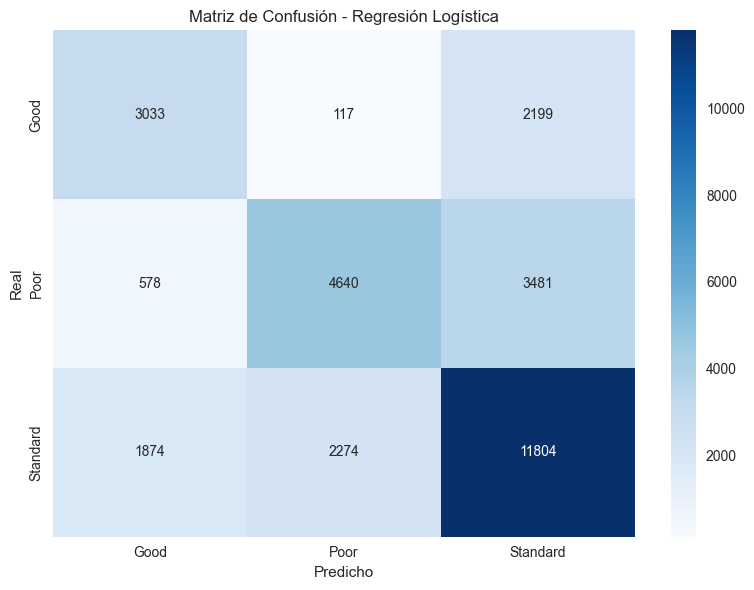


🎯 RESUMEN FINAL - REGRESIÓN LOGÍSTICA
⏱️  Tiempo ejecución: 16.98s
📈 Accuracy: 0.6492 (64.92%)
🎯 Validación Cruzada: 0.6501 ± 0.0054
🔝 Característica más importante: payment_behaviour_Low_spent_Small_value_payments
💾 Resultados guardados: 'logreg_benchmark_results.pkl'


In [7]:
# REGRESIÓN LOGÍSTICA - MODELO BENCHMARK

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

print("🚀 INICIANDO REGRESIÓN LOGÍSTICA - MODELO BENCHMARK...")
start_time = time.time()

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# =============================================================================
# PREPROCESAMIENTO
# =============================================================================

# Cargar datos
df = pd.read_pickle('data_limpia.pkl')

# Separar características y target
X = df.drop('credit_score', axis=1)
y = df['credit_score']

# Split de datos ANTES de la codificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Identificar columnas categóricas y numéricas
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=[np.number]).columns

# Crear el preprocesador con OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ]
)

# Aplicar transformaciones
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Codificar target
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print(f"✅ Datos preparados: {X_train_processed.shape[0]} train, {X_test_processed.shape[0]} test")

# =============================================================================
# ENTRENAMIENTO DEL MODELO
# =============================================================================

print(f"\n🎯 ENTRENANDO MODELO REGRESIÓN LOGÍSTICA...")

lr_model = LogisticRegression(
    C=1.0,
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)

lr_model.fit(X_train_processed, y_train_encoded)

# Predicciones
y_pred = lr_model.predict(X_test_processed)
y_pred_proba = lr_model.predict_proba(X_test_processed)

# =============================================================================
# EVALUACIÓN
# =============================================================================

print("\n📈 EVALUANDO MODELO REGRESIÓN LOGÍSTICA...")

accuracy = accuracy_score(y_test_encoded, y_pred)
precision = precision_score(y_test_encoded, y_pred, average='weighted')
recall = recall_score(y_test_encoded, y_pred, average='weighted')
f1 = f1_score(y_test_encoded, y_pred, average='weighted')

cv_scores = cross_val_score(lr_model, X_train_processed, y_train_encoded, cv=5, scoring='accuracy')

print(f"📊 MÉTRICAS DEL MODELO REGRESIÓN LOGÍSTICA:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"CV Mean: {cv_scores.mean():.4f}")
print(f"CV Std: {cv_scores.std():.4f}")

# Reporte de clasificación
print("\n📋 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))

# =============================================================================
# TABLA DE MÉTRICAS POR CLASE
# =============================================================================

from sklearn.metrics import precision_recall_fscore_support

# Calcular métricas por clase
precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    y_test_encoded, y_pred, labels=[0, 1, 2]
)

# Crear tabla de métricas por clase
class_report_df = pd.DataFrame({
    'precision': precision_per_class,
    'recall': recall_per_class,
    'f1-score': f1_per_class,
    'support': support_per_class
}, index=le.classes_)

# Calcular promedios
macro_avg = class_report_df[['precision', 'recall', 'f1-score']].mean()
weighted_avg = np.average(class_report_df[['precision', 'recall', 'f1-score']], 
                         weights=class_report_df['support'], axis=0)

# Agregar filas de promedios
class_report_df.loc['macro avg'] = [macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], class_report_df['support'].sum()]
class_report_df.loc['weighted avg'] = [weighted_avg[0], weighted_avg[1], weighted_avg[2], class_report_df['support'].sum()]
class_report_df.loc['accuracy'] = [accuracy, '', '', class_report_df['support'].sum()]

print("\n📊 TABLA DE MÉTRICAS POR CLASE:")
print("="*60)
print(f"{'':<12} {'precision':<10} {'recall':<10} {'f1-score':<10} {'support':<10}")
print("-" * 60)
for idx, row in class_report_df.iterrows():
    if idx == 'accuracy':
        print(f"{idx:<12} {'':<10} {'':<10} {'':<10} {row['support']:<10}")
        print(f"{'':<12} {'':<10} {'':<10} {row['precision']:<10.2f} {'':<10}")
    else:
        print(f"{idx:<12} {row['precision']:<10.2f} {row['recall']:<10.2f} {row['f1-score']:<10.2f} {row['support']:<10}")
print("="*60)

# =============================================================================
# ANÁLISIS DE COEFICIENTES
# =============================================================================

print(f"\n🔍 ANÁLISIS DE COEFICIENTES:")

# Obtener nombres de características del preprocesador
feature_names = (list(numerical_cols) + 
                list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)))

coefficients = lr_model.coef_

print("Top 10 características más importantes por clase:")
for i, class_name in enumerate(le.classes_):
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients[i]
    }).sort_values('Coefficient', key=abs, ascending=False)
    
    print(f"\n📊 Clase '{class_name}':")
    print(coef_df.head(10).round(4))

# =============================================================================
# VISUALIZACIONES
# =============================================================================

plt.figure(figsize=(8, 6))

# Matriz de confusión
cm = confusion_matrix(y_test_encoded, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusión - Regresión Logística')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.tight_layout()
plt.show()

# =============================================================================
# RESUMEN FINAL
# =============================================================================

end_time = time.time()
execution_time = end_time - start_time

print("\n" + "="*60)
print("🎯 RESUMEN FINAL - REGRESIÓN LOGÍSTICA")
print("="*60)

print(f"⏱️  Tiempo ejecución: {execution_time:.2f}s")
print(f"📈 Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"🎯 Validación Cruzada: {cv_scores.mean():.4f} ± {cv_scores.std()*2:.4f}")

# Característica más importante
best_coefs = lr_model.coef_[0]
top_feature_idx = np.argmax(np.abs(best_coefs))
print(f"🔝 Característica más importante: {feature_names[top_feature_idx]}")

# Guardar modelo para benchmark comparativo
benchmark_data = {
    'model': 'LogisticRegression',
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'cv_mean': cv_scores.mean(),
    'cv_std': cv_scores.std(),
    'execution_time': execution_time,
    'coefficients': lr_model.coef_,
    'classification_report': class_report_df
}

joblib.dump(benchmark_data, 'logreg_benchmark_results.pkl')
print(f"💾 Resultados guardados: 'logreg_benchmark_results.pkl'")
print("="*60)

## Ridge

🚀 INICIANDO RIDGE CLASSIFICATION - MODELO BENCHMARK...
✅ Datos preparados: 70000 train, 30000 test

🎯 ENTRENANDO MODELO RIDGE...

📈 EVALUANDO MODELO RIDGE...
📊 MÉTRICAS DEL MODELO RIDGE:
Accuracy: 0.6404
Precision: 0.6481
Recall: 0.6404
F1-Score: 0.6411
CV Mean: 0.6393
CV Std: 0.0021

📋 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

        Good       0.49      0.63      0.55      5349
        Poor       0.65      0.54      0.59      8699
    Standard       0.70      0.70      0.70     15952

    accuracy                           0.64     30000
   macro avg       0.61      0.62      0.61     30000
weighted avg       0.65      0.64      0.64     30000


📊 TABLA DE MÉTRICAS POR CLASE:
             precision  recall     f1-score   support   
------------------------------------------------------------
Good         0.49       0.63       0.55       5349.0    
Poor         0.65       0.54       0.59       8699.0    
Standard     0.70       0.70       0.70  

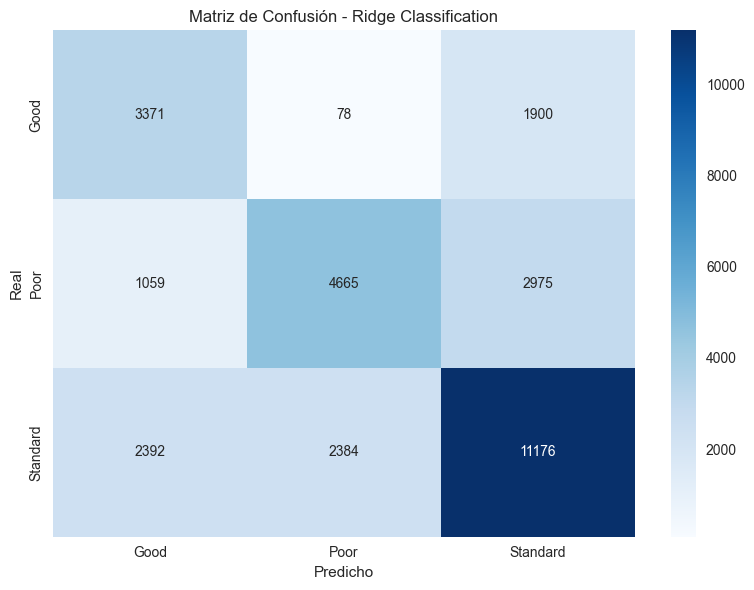


🎯 RESUMEN FINAL - RIDGE CLASSIFICATION
⏱️  Tiempo ejecución: 1.03s
📈 Accuracy: 0.6404 (64.04%)
🎯 Validación Cruzada: 0.6393 ± 0.0041
💾 Resultados guardados: 'ridge_benchmark_results.pkl'


In [4]:
# =============================================================================
# RIDGE CLASSIFICATION - MODELO BENCHMARK
# =============================================================================

import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

print("🚀 INICIANDO RIDGE CLASSIFICATION - MODELO BENCHMARK...")
start_time = time.time()

# =============================================================================
# CONFIGURACIÓN
# =============================================================================

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# =============================================================================
# PREPROCESAMIENTO
# =============================================================================

# Cargar datos
df = pd.read_pickle('data_limpia.pkl')

# Separar características y target
X = df.drop('credit_score', axis=1)
y = df['credit_score']

# Split de datos ANTES de la codificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Identificar columnas categóricas y numéricas
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=[np.number]).columns

# Crear el preprocesador con OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ]
)

# Aplicar transformaciones
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Codificar target
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print(f"✅ Datos preparados: {X_train_processed.shape[0]} train, {X_test_processed.shape[0]} test")

# =============================================================================
# ENTRENAMIENTO DEL MODELO
# =============================================================================

print(f"\n🎯 ENTRENANDO MODELO RIDGE...")

ridge_model = RidgeClassifier(
    alpha=1.0,
    random_state=42,
    max_iter=1000
)

ridge_model.fit(X_train_processed, y_train_encoded)

# Predicciones
y_pred = ridge_model.predict(X_test_processed)

# =============================================================================
# EVALUACIÓN COMPLETA
# =============================================================================

print("\n📈 EVALUANDO MODELO RIDGE...")

# Métricas principales
accuracy = accuracy_score(y_test_encoded, y_pred)
precision = precision_score(y_test_encoded, y_pred, average='weighted')
recall = recall_score(y_test_encoded, y_pred, average='weighted')
f1 = f1_score(y_test_encoded, y_pred, average='weighted')

# Validación cruzada
cv_scores = cross_val_score(ridge_model, X_train_processed, y_train_encoded, cv=5, scoring='accuracy')

print(f"📊 MÉTRICAS DEL MODELO RIDGE:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"CV Mean: {cv_scores.mean():.4f}")
print(f"CV Std: {cv_scores.std():.4f}")

# Reporte de clasificación
print("\n📋 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))

# =============================================================================
# TABLA DE MÉTRICAS POR CLASE
# =============================================================================

from sklearn.metrics import precision_recall_fscore_support

# Calcular métricas por clase
precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    y_test_encoded, y_pred, labels=[0, 1, 2]
)

# Crear tabla de métricas por clase
class_report_df = pd.DataFrame({
    'precision': precision_per_class,
    'recall': recall_per_class,
    'f1-score': f1_per_class,
    'support': support_per_class
}, index=le.classes_)

# Calcular promedios
macro_avg = class_report_df[['precision', 'recall', 'f1-score']].mean()
weighted_avg = np.average(class_report_df[['precision', 'recall', 'f1-score']], 
                         weights=class_report_df['support'], axis=0)

# Agregar filas de promedios
class_report_df.loc['macro avg'] = [macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], class_report_df['support'].sum()]
class_report_df.loc['weighted avg'] = [weighted_avg[0], weighted_avg[1], weighted_avg[2], class_report_df['support'].sum()]
class_report_df.loc['accuracy'] = [accuracy, '', '', class_report_df['support'].sum()]

print("\n📊 TABLA DE MÉTRICAS POR CLASE:")
print("="*60)
print(f"{'':<12} {'precision':<10} {'recall':<10} {'f1-score':<10} {'support':<10}")
print("-" * 60)
for idx, row in class_report_df.iterrows():
    if idx == 'accuracy':
        print(f"{idx:<12} {'':<10} {'':<10} {'':<10} {row['support']:<10}")
        print(f"{'':<12} {'':<10} {'':<10} {row['precision']:<10.2f} {'':<10}")
    else:
        print(f"{idx:<12} {row['precision']:<10.2f} {row['recall']:<10.2f} {row['f1-score']:<10.2f} {row['support']:<10}")
print("="*60)

# =============================================================================
# VISUALIZACIONES
# =============================================================================

plt.figure(figsize=(8, 6))

# Matriz de confusión
cm = confusion_matrix(y_test_encoded, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusión - Ridge Classification')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.tight_layout()
plt.show()

# =============================================================================
# RESUMEN FINAL
# =============================================================================

end_time = time.time()
execution_time = end_time - start_time

print("\n" + "="*60)
print("🎯 RESUMEN FINAL - RIDGE CLASSIFICATION")
print("="*60)

print(f"⏱️  Tiempo ejecución: {execution_time:.2f}s")
print(f"📈 Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"🎯 Validación Cruzada: {cv_scores.mean():.4f} ± {cv_scores.std()*2:.4f}")

# Guardar modelo para benchmark comparativo
benchmark_data = {
    'model': 'RidgeClassifier',
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'cv_mean': cv_scores.mean(),
    'cv_std': cv_scores.std(),
    'execution_time': execution_time,
    'coefficients': ridge_model.coef_,
    'classification_report': class_report_df
}

joblib.dump(benchmark_data, 'ridge_benchmark_results.pkl')
print(f"💾 Resultados guardados: 'ridge_benchmark_results.pkl'")
print("="*60)

## Lasso

In [ ]:
# =============================================================================

## Árbol de Decisión

🌳 INICIANDO ÁRBOL DE DECISIÓN - MODELO BENCHMARK...
✅ Datos preparados: 70000 train, 30000 test

🎯 ENTRENANDO MODELO ÁRBOL DE DECISIÓN...

📈 EVALUANDO MODELO ÁRBOL DE DECISIÓN...
📊 MÉTRICAS DEL MODELO ÁRBOL DE DECISIÓN:
Accuracy: 0.6721
Precision: 0.6937
Recall: 0.6721
F1-Score: 0.6754
CV Mean: 0.6741
CV Std: 0.0034

📋 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

        Good       0.50      0.76      0.60      5349
        Poor       0.74      0.59      0.65      8699
    Standard       0.74      0.69      0.71     15952

    accuracy                           0.67     30000
   macro avg       0.66      0.68      0.66     30000
weighted avg       0.69      0.67      0.68     30000


📊 TABLA DE MÉTRICAS POR CLASE:
             precision  recall     f1-score   support   
------------------------------------------------------------
Good         0.50       0.76       0.60       5349.0    
Poor         0.74       0.59       0.65       8699.0    
Standard

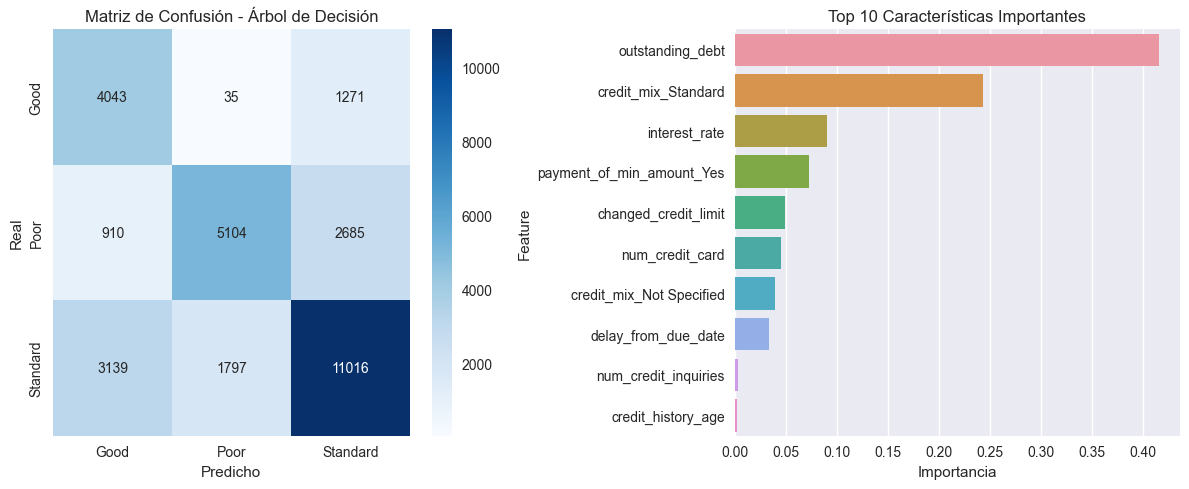


🎯 RESUMEN FINAL - ÁRBOL DE DECISIÓN
⏱️  Tiempo ejecución: 4.45s
📈 Accuracy: 0.6721 (67.21%)
🎯 Validación Cruzada: 0.6741 ± 0.0068
📊 Característica más importante: outstanding_debt
🌳 Profundidad del árbol: 5
🍃 Número de hojas: 32
💾 Resultados guardados: 'decision_tree_benchmark_results.pkl'


In [8]:
# ÁRBOL DE DECISIÓN - MODELO BENCHMARK

import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
import numpy as np
import pandas as pd

print("🌳 INICIANDO ÁRBOL DE DECISIÓN - MODELO BENCHMARK...")
start_time = time.time()

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# =============================================================================
# PREPROCESAMIENTO
# =============================================================================

# Cargar datos
df = pd.read_pickle('data_limpia.pkl')

# Separar características y target
X = df.drop('credit_score', axis=1)
y = df['credit_score']

# Split de datos ANTES de la codificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Identificar columnas categóricas y numéricas
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=[np.number]).columns

# Crear el preprocesador con OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ]
)

# Aplicar transformaciones
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Codificar target
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print(f"✅ Datos preparados: {X_train_processed.shape[0]} train, {X_test_processed.shape[0]} test")

# =============================================================================
# ENTRENAMIENTO DEL MODELO
# =============================================================================

print(f"\n🎯 ENTRENANDO MODELO ÁRBOL DE DECISIÓN...")

dt_model = DecisionTreeClassifier(
    max_depth=5,
    random_state=42
)

dt_model.fit(X_train_processed, y_train_encoded)

y_pred = dt_model.predict(X_test_processed)

# =============================================================================
# EVALUACIÓN
# =============================================================================

print("\n📈 EVALUANDO MODELO ÁRBOL DE DECISIÓN...")

accuracy = accuracy_score(y_test_encoded, y_pred)
precision = precision_score(y_test_encoded, y_pred, average='weighted')
recall = recall_score(y_test_encoded, y_pred, average='weighted')
f1 = f1_score(y_test_encoded, y_pred, average='weighted')

cv_scores = cross_val_score(dt_model, X_train_processed, y_train_encoded, cv=5, scoring='accuracy')

print(f"📊 MÉTRICAS DEL MODELO ÁRBOL DE DECISIÓN:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"CV Mean: {cv_scores.mean():.4f}")
print(f"CV Std: {cv_scores.std():.4f}")

# Reporte de clasificación
print("\n📋 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))

# =============================================================================
# TABLA DE MÉTRICAS POR CLASE
# =============================================================================

from sklearn.metrics import precision_recall_fscore_support

# Calcular métricas por clase
precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    y_test_encoded, y_pred, labels=[0, 1, 2]
)

# Crear tabla de métricas por clase
class_report_df = pd.DataFrame({
    'precision': precision_per_class,
    'recall': recall_per_class,
    'f1-score': f1_per_class,
    'support': support_per_class
}, index=le.classes_)

# Calcular promedios
macro_avg = class_report_df[['precision', 'recall', 'f1-score']].mean()
weighted_avg = np.average(class_report_df[['precision', 'recall', 'f1-score']], 
                         weights=class_report_df['support'], axis=0)

# Agregar filas de promedios
class_report_df.loc['macro avg'] = [macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], class_report_df['support'].sum()]
class_report_df.loc['weighted avg'] = [weighted_avg[0], weighted_avg[1], weighted_avg[2], class_report_df['support'].sum()]
class_report_df.loc['accuracy'] = [accuracy, '', '', class_report_df['support'].sum()]

print("\n📊 TABLA DE MÉTRICAS POR CLASE:")
print("="*60)
print(f"{'':<12} {'precision':<10} {'recall':<10} {'f1-score':<10} {'support':<10}")
print("-" * 60)
for idx, row in class_report_df.iterrows():
    if idx == 'accuracy':
        print(f"{idx:<12} {'':<10} {'':<10} {'':<10} {row['support']:<10}")
        print(f"{'':<12} {'':<10} {'':<10} {row['precision']:<10.2f} {'':<10}")
    else:
        print(f"{idx:<12} {row['precision']:<10.2f} {row['recall']:<10.2f} {row['f1-score']:<10.2f} {row['support']:<10}")
print("="*60)

# =============================================================================
# ANÁLISIS DE CARACTERÍSTICAS
# =============================================================================

print(f"\n🔍 IMPORTANCIA DE CARACTERÍSTICAS:")

# Obtener nombres de características del preprocesador
feature_names = (list(numerical_cols) + 
                list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)))

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 características más importantes:")
print(feature_importance.head(10).round(4))

# =============================================================================
# VISUALIZACIONES
# =============================================================================

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test_encoded, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusión - Árbol de Decisión')
plt.ylabel('Real')
plt.xlabel('Predicho')

plt.subplot(1, 2, 2)
top_features = feature_importance.head(10)
sns.barplot(data=top_features, x='Importance', y='Feature')
plt.title('Top 10 Características Importantes')
plt.xlabel('Importancia')

plt.tight_layout()
plt.show()

# =============================================================================
# RESUMEN FINAL
# =============================================================================

end_time = time.time()
execution_time = end_time - start_time

print("\n" + "="*60)
print("🎯 RESUMEN FINAL - ÁRBOL DE DECISIÓN")
print("="*60)

print(f"⏱️  Tiempo ejecución: {execution_time:.2f}s")
print(f"📈 Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"🎯 Validación Cruzada: {cv_scores.mean():.4f} ± {cv_scores.std()*2:.4f}")
print(f"📊 Característica más importante: {feature_importance.iloc[0]['Feature']}")
print(f"🌳 Profundidad del árbol: {dt_model.get_depth()}")
print(f"🍃 Número de hojas: {dt_model.get_n_leaves()}")

# Guardar modelo para benchmark comparativo
benchmark_data = {
    'model': 'DecisionTree',
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'cv_mean': cv_scores.mean(),
    'cv_std': cv_scores.std(),
    'execution_time': execution_time,
    'feature_importance': feature_importance,
    'classification_report': class_report_df,
    'tree_depth': dt_model.get_depth(),
    'n_leaves': dt_model.get_n_leaves()
}

joblib.dump(benchmark_data, 'decision_tree_benchmark_results.pkl')
print(f"💾 Resultados guardados: 'decision_tree_benchmark_results.pkl'")
print("="*60)

## Random Forest

🌲 INICIANDO RANDOM FOREST - MODELO BENCHMARK...
✅ Datos preparados: 70000 train, 30000 test

🎯 ENTRENANDO MODELO RANDOM FOREST...

📈 EVALUANDO MODELO RANDOM FOREST...
📊 MÉTRICAS DEL MODELO RANDOM FOREST:
Accuracy: 0.7852
Precision: 0.7853
Recall: 0.7852
F1-Score: 0.7852
CV Mean: 0.7736
CV Std: 0.0048

📋 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

        Good       0.73      0.73      0.73      5349
        Poor       0.78      0.79      0.78      8699
    Standard       0.81      0.80      0.81     15952

    accuracy                           0.79     30000
   macro avg       0.77      0.77      0.77     30000
weighted avg       0.79      0.79      0.79     30000


📊 TABLA DE MÉTRICAS POR CLASE:
             precision  recall     f1-score   support   
------------------------------------------------------------
Good         0.73       0.73       0.73       5349.0    
Poor         0.78       0.79       0.78       8699.0    
Standard     0.81       

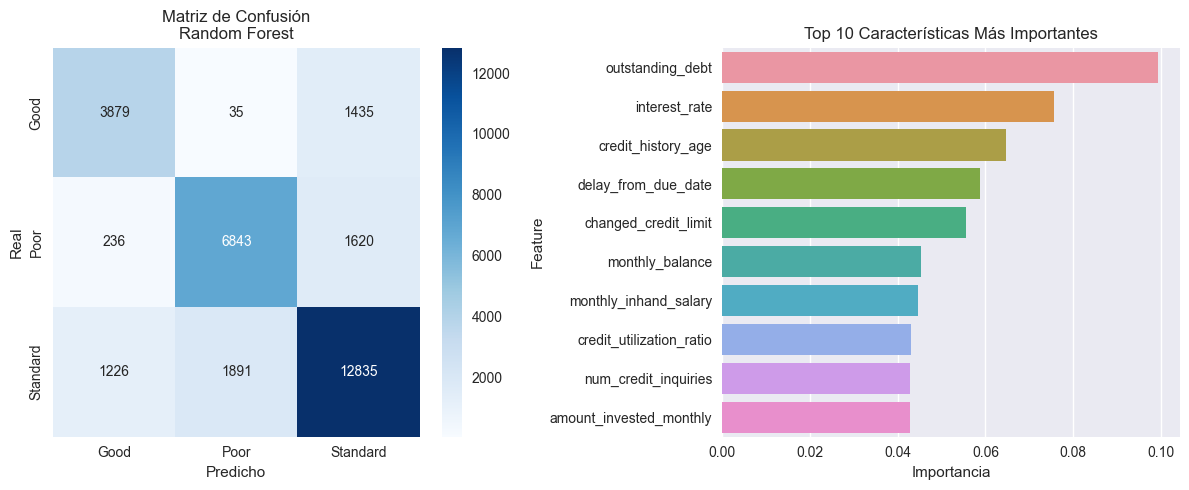


🎯 RESUMEN FINAL - RANDOM FOREST
⏱️  Tiempo ejecución: 22.57s
📈 Accuracy: 0.7852 (78.52%)
🎯 Validación Cruzada: 0.7736 ± 0.0095
📊 Característica más importante: outstanding_debt
💾 Resultados guardados: 'random_forest_benchmark_results.pkl'


In [5]:
# =============================================================================
# RANDOM FOREST - MODELO BENCHMARK
# =============================================================================

import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

print("🌲 INICIANDO RANDOM FOREST - MODELO BENCHMARK...")
start_time = time.time()

# =============================================================================
# PREPROCESAMIENTO
# =============================================================================

# Cargar datos
df = pd.read_pickle('data_limpia.pkl')

# Separar características y target
X = df.drop('credit_score', axis=1)
y = df['credit_score']

# Split de datos ANTES de la codificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Identificar columnas categóricas y numéricas
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=[np.number]).columns

# Crear el preprocesador con OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ]
)

# Aplicar transformaciones
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Codificar target
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print(f"✅ Datos preparados: {X_train_processed.shape[0]} train, {X_test_processed.shape[0]} test")

# =============================================================================
# ENTRENAMIENTO DEL MODELO
# =============================================================================

print(f"\n🎯 ENTRENANDO MODELO RANDOM FOREST...")

rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_processed, y_train_encoded)

y_pred = rf_model.predict(X_test_processed)

# =============================================================================
# EVALUACIÓN
# =============================================================================

print("\n📈 EVALUANDO MODELO RANDOM FOREST...")

accuracy = accuracy_score(y_test_encoded, y_pred)
precision = precision_score(y_test_encoded, y_pred, average='weighted')
recall = recall_score(y_test_encoded, y_pred, average='weighted')
f1 = f1_score(y_test_encoded, y_pred, average='weighted')

cv_scores = cross_val_score(rf_model, X_train_processed, y_train_encoded, cv=5, scoring='accuracy')

print(f"📊 MÉTRICAS DEL MODELO RANDOM FOREST:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"CV Mean: {cv_scores.mean():.4f}")
print(f"CV Std: {cv_scores.std():.4f}")

# Reporte de clasificación
print("\n📋 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))

# =============================================================================
# TABLA DE MÉTRICAS POR CLASE
# =============================================================================

from sklearn.metrics import precision_recall_fscore_support

# Calcular métricas por clase
precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    y_test_encoded, y_pred, labels=[0, 1, 2]
)

# Crear tabla de métricas por clase
class_report_df = pd.DataFrame({
    'precision': precision_per_class,
    'recall': recall_per_class,
    'f1-score': f1_per_class,
    'support': support_per_class
}, index=le.classes_)

# Calcular promedios
macro_avg = class_report_df[['precision', 'recall', 'f1-score']].mean()
weighted_avg = np.average(class_report_df[['precision', 'recall', 'f1-score']], 
                         weights=class_report_df['support'], axis=0)

# Agregar filas de promedios
class_report_df.loc['macro avg'] = [macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], class_report_df['support'].sum()]
class_report_df.loc['weighted avg'] = [weighted_avg[0], weighted_avg[1], weighted_avg[2], class_report_df['support'].sum()]
class_report_df.loc['accuracy'] = [accuracy, '', '', class_report_df['support'].sum()]

print("\n📊 TABLA DE MÉTRICAS POR CLASE:")
print("="*60)
print(f"{'':<12} {'precision':<10} {'recall':<10} {'f1-score':<10} {'support':<10}")
print("-" * 60)
for idx, row in class_report_df.iterrows():
    if idx == 'accuracy':
        print(f"{idx:<12} {'':<10} {'':<10} {'':<10} {row['support']:<10}")
        print(f"{'':<12} {'':<10} {'':<10} {row['precision']:<10.2f} {'':<10}")
    else:
        print(f"{idx:<12} {row['precision']:<10.2f} {row['recall']:<10.2f} {row['f1-score']:<10.2f} {row['support']:<10}")
print("="*60)

# =============================================================================
# ANÁLISIS DE CARACTERÍSTICAS
# =============================================================================

print(f"\n🔍 ANALISIS DE IMPORTANCIA DE CARACTERÍSTICAS:")

# Obtener nombres de características del preprocesador
feature_names = (list(numerical_cols) + 
                list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)))

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 características más importantes:")
print(feature_importance.head(10).round(4))

# =============================================================================
# VISUALIZACIONES
# =============================================================================

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test_encoded, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusión\nRandom Forest')
plt.ylabel('Real')
plt.xlabel('Predicho')

plt.subplot(1, 2, 2)
top_features = feature_importance.head(10)
sns.barplot(data=top_features, x='Importance', y='Feature')
plt.title('Top 10 Características Más Importantes')
plt.xlabel('Importancia')

plt.tight_layout()
plt.show()

# =============================================================================
# RESUMEN FINAL
# =============================================================================

end_time = time.time()
execution_time = end_time - start_time

print("\n" + "="*60)
print("🎯 RESUMEN FINAL - RANDOM FOREST")
print("="*60)

print(f"⏱️  Tiempo ejecución: {execution_time:.2f}s")
print(f"📈 Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"🎯 Validación Cruzada: {cv_scores.mean():.4f} ± {cv_scores.std()*2:.4f}")
print(f"📊 Característica más importante: {feature_importance.iloc[0]['Feature']}")

# Guardar modelo para benchmark comparativo
benchmark_data = {
    'model': 'RandomForest',
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'cv_mean': cv_scores.mean(),
    'cv_std': cv_scores.std(),
    'execution_time': execution_time,
    'feature_importance': feature_importance,
    'classification_report': class_report_df
}

joblib.dump(benchmark_data, 'random_forest_benchmark_results.pkl')
print(f"💾 Resultados guardados: 'random_forest_benchmark_results.pkl'")
print("="*60)

## XGBoost (con interpretabilidad usando LIME)

In [ ]:
#!pip install xgboost lime

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 1.0/124.9 MB 6.3 MB/s eta 0:00:20
    --------------------------------------- 2.4/124.9 MB 5.8 MB/s eta 0:00:21
   - -------------------------------------- 3.7/124.9 MB 5.9 MB/s eta 0:00:21
   - -------------------------------------- 5.0/124.9 MB 6.0 MB/s eta 0:00:20
   -- ------------------------------------- 6.6/124.9 MB 6.2 MB/s eta 0:00:20
   -- ------------------------------------- 7.9/124.9 MB 6.3 MB/s eta 0:00:19
   -- ------------------------------------- 9.2/124.9 MB 6.3 MB/s eta 0:00:19
   --- ------------------------------------ 10.7/124.9 MB 6.5 MB/s eta 0:00:18
   --- ------------------------------------ 12.3/124.9 MB 6.5 MB/s eta 0:00:18
   ---- ----------------------------------- 13.9/124.9 MB 6.6 MB/s eta 0:00:17
   ---- ----------------------------------- 

  DEPRECATION: Building 'lime' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'lime'. Discussion can be found at https://github.com/pypa/pip/issues/6334


🚀 INICIANDO XGBOOST - MODELO BENCHMARK...
✅ Datos preparados: 70000 train, 30000 test

🎯 ENTRENANDO MODELO XGBOOST...

📈 EVALUANDO MODELO XGBOOST...
📊 MÉTRICAS DEL MODELO XGBOOST:
Accuracy: 0.7515
Precision: 0.7519
Recall: 0.7515
F1-Score: 0.7516
CV Mean: 0.7488
CV Std: 0.0040

📋 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

        Good       0.67      0.69      0.68      5349
        Poor       0.75      0.73      0.74      8699
    Standard       0.78      0.78      0.78     15952

    accuracy                           0.75     30000
   macro avg       0.73      0.74      0.73     30000
weighted avg       0.75      0.75      0.75     30000


📊 TABLA DE MÉTRICAS POR CLASE:
             precision  recall     f1-score   support   
------------------------------------------------------------
Good         0.67       0.69       0.68       5349.0    
Poor         0.75       0.73       0.74       8699.0    
Standard     0.78       0.78       0.78       15

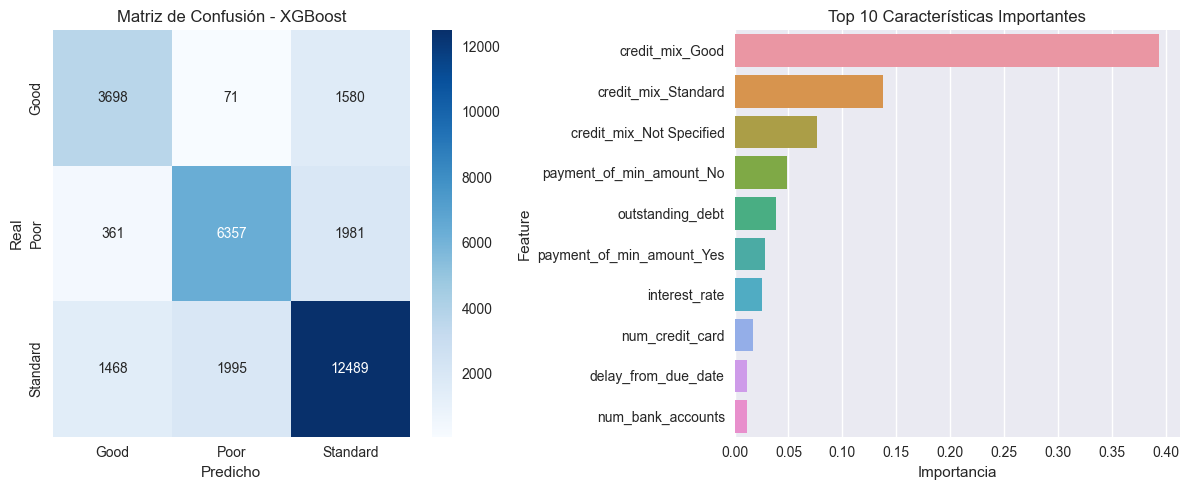


🎯 RESUMEN FINAL - XGBOOST
⏱️  Tiempo ejecución: 6.78s
📈 Accuracy: 0.7515 (75.15%)
🎯 Validación Cruzada: 0.7488 ± 0.0079
📊 Característica más importante: credit_mix_Good
💾 Resultados guardados: 'xgboost_benchmark_results.pkl'


In [6]:
# XGBOOST - MODELO BENCHMARK

import warnings
warnings.filterwarnings('ignore')
import sys
import subprocess

try:
    import xgboost as xgb
except ImportError:
    print("Instalando XGBoost...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost"])
    import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
import numpy as np
import pandas as pd

print("🚀 INICIANDO XGBOOST - MODELO BENCHMARK...")
start_time = time.time()

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# =============================================================================
# PREPROCESAMIENTO
# =============================================================================

# Cargar datos
df = pd.read_pickle('data_limpia.pkl')

# Separar características y target
X = df.drop('credit_score', axis=1)
y = df['credit_score']

# Split de datos ANTES de la codificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Identificar columnas categóricas y numéricas
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=[np.number]).columns

# Crear el preprocesador con OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ]
)

# Aplicar transformaciones
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Codificar target
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print(f"✅ Datos preparados: {X_train_processed.shape[0]} train, {X_test_processed.shape[0]} test")

# =============================================================================
# ENTRENAMIENTO DEL MODELO
# =============================================================================

print(f"\n🎯 ENTRENANDO MODELO XGBOOST...")

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

xgb_model.fit(X_train_processed, y_train_encoded)

y_pred = xgb_model.predict(X_test_processed)
y_pred_proba = xgb_model.predict_proba(X_test_processed)

# =============================================================================
# EVALUACIÓN
# =============================================================================

print("\n📈 EVALUANDO MODELO XGBOOST...")

accuracy = accuracy_score(y_test_encoded, y_pred)
precision = precision_score(y_test_encoded, y_pred, average='weighted')
recall = recall_score(y_test_encoded, y_pred, average='weighted')
f1 = f1_score(y_test_encoded, y_pred, average='weighted')

cv_scores = cross_val_score(xgb_model, X_train_processed, y_train_encoded, cv=5, scoring='accuracy')

print(f"📊 MÉTRICAS DEL MODELO XGBOOST:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"CV Mean: {cv_scores.mean():.4f}")
print(f"CV Std: {cv_scores.std():.4f}")

# Reporte de clasificación
print("\n📋 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))

# =============================================================================
# TABLA DE MÉTRICAS POR CLASE
# =============================================================================

from sklearn.metrics import precision_recall_fscore_support

# Calcular métricas por clase
precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    y_test_encoded, y_pred, labels=[0, 1, 2]
)

# Crear tabla de métricas por clase
class_report_df = pd.DataFrame({
    'precision': precision_per_class,
    'recall': recall_per_class,
    'f1-score': f1_per_class,
    'support': support_per_class
}, index=le.classes_)

# Calcular promedios
macro_avg = class_report_df[['precision', 'recall', 'f1-score']].mean()
weighted_avg = np.average(class_report_df[['precision', 'recall', 'f1-score']], 
                         weights=class_report_df['support'], axis=0)

# Agregar filas de promedios
class_report_df.loc['macro avg'] = [macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], class_report_df['support'].sum()]
class_report_df.loc['weighted avg'] = [weighted_avg[0], weighted_avg[1], weighted_avg[2], class_report_df['support'].sum()]
class_report_df.loc['accuracy'] = [accuracy, '', '', class_report_df['support'].sum()]

print("\n📊 TABLA DE MÉTRICAS POR CLASE:")
print("="*60)
print(f"{'':<12} {'precision':<10} {'recall':<10} {'f1-score':<10} {'support':<10}")
print("-" * 60)
for idx, row in class_report_df.iterrows():
    if idx == 'accuracy':
        print(f"{idx:<12} {'':<10} {'':<10} {'':<10} {row['support']:<10}")
        print(f"{'':<12} {'':<10} {'':<10} {row['precision']:<10.2f} {'':<10}")
    else:
        print(f"{idx:<12} {row['precision']:<10.2f} {row['recall']:<10.2f} {row['f1-score']:<10.2f} {row['support']:<10}")
print("="*60)

# =============================================================================
# ANÁLISIS DE CARACTERÍSTICAS
# =============================================================================

print(f"\n🔍 IMPORTANCIA DE CARACTERÍSTICAS:")

# Obtener nombres de características del preprocesador
feature_names = (list(numerical_cols) + 
                list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)))

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 características más importantes:")
print(feature_importance.head(10).round(4))

# =============================================================================
# VISUALIZACIONES
# =============================================================================

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test_encoded, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusión - XGBoost')
plt.ylabel('Real')
plt.xlabel('Predicho')

plt.subplot(1, 2, 2)
top_features = feature_importance.head(10)
sns.barplot(data=top_features, x='Importance', y='Feature')
plt.title('Top 10 Características Importantes')
plt.xlabel('Importancia')

plt.tight_layout()
plt.show()

# =============================================================================
# RESUMEN FINAL
# =============================================================================

end_time = time.time()
execution_time = end_time - start_time

print("\n" + "="*60)
print("🎯 RESUMEN FINAL - XGBOOST")
print("="*60)

print(f"⏱️  Tiempo ejecución: {execution_time:.2f}s")
print(f"📈 Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"🎯 Validación Cruzada: {cv_scores.mean():.4f} ± {cv_scores.std()*2:.4f}")
print(f"📊 Característica más importante: {feature_importance.iloc[0]['Feature']}")

# Guardar modelo para benchmark comparativo
benchmark_data = {
    'model': 'XGBoost',
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'cv_mean': cv_scores.mean(),
    'cv_std': cv_scores.std(),
    'execution_time': execution_time,
    'feature_importance': feature_importance,
    'classification_report': class_report_df
}

joblib.dump(benchmark_data, 'xgboost_benchmark_results.pkl')
print(f"💾 Resultados guardados: 'xgboost_benchmark_results.pkl'")
print("="*60)

## Máquina de Soporte Vectorial

🚀 INICIANDO MAQUÍNA DE SOPORTE VECTORIAL - MODELO BENCHMARK...
✅ Datos preparados: 70000 train, 30000 test

🎯 ENTRENANDO MODELO 

📈 EVALUANDO MODELO DE MÁQUINA DE VECTORES DE SOPORTE...

📋 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

        Good       0.57      0.67      0.62      5349
        Poor       0.74      0.63      0.68      8699
    Standard       0.74      0.76      0.75     15952

    accuracy                           0.70     30000
   macro avg       0.68      0.69      0.68     30000
weighted avg       0.71      0.70      0.70     30000



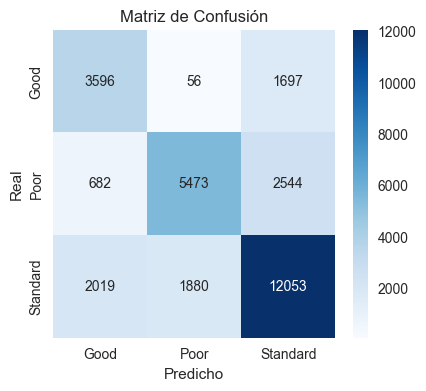


🔍 ANÁLISIS DE ERRORES POR CLASE:
Accuracy por clase:
  Good: 0.6723 (67.23%)
  Poor: 0.6292 (62.92%)
  Standard: 0.7556 (75.56%)

🎯 RESUMEN FINAL - MÁQUINA DE VECTORES DE SOPORTE BENCHMARK
⏱️  Tiempo ejecución: 446.70s

🎯 EVALUACIÓN: ⚠️  ACEPTABLE

💾 Resultados guardados: 'svm_benchmark_results.pkl'


In [ ]:
# =============================================================================
# MÁQUINA DE SOPORTE VECTORIAL - MODELO BENCHMARK
# =============================================================================

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Configuración
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 INICIANDO MAQUÍNA DE SOPORTE VECTORIAL - MODELO BENCHMARK...")
start_time = time.time()

# =============================================================================
# PREPROCESAMIENTO
# =============================================================================


# Separar características y target
X = df.drop('credit_score', axis=1)
y = df['credit_score']

y = y.map({
    'Good': 0,
    'Poor': 1,
    'Standard': 2
    
})


# Seleccionamos las variables numericas a estandarizar
num_cols=['age', 'monthly_inhand_salary',
          'num_bank_accounts', 'num_credit_card', 'interest_rate',
          'delay_from_due_date', 'num_of_delayed_payment','changed_credit_limit',
          'num_credit_inquiries', 'outstanding_debt', 'credit_utilization_ratio',
          'credit_history_age','total_emi_per_month', 'amount_invested_monthly',
          'monthly_balance']

# Seleccionamos las variables categóricas a codificar
cat_cols=['occupation', 'credit_mix', 'payment_of_min_amount','payment_behaviour']
# Se no se toman las variables binarias ya que estas ya pueden considerarse
# como codificadas


# Split de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Codificación de categóricas
ohe = OneHotEncoder(drop="first", handle_unknown="ignore", sparse=False)

X_train_cat = ohe.fit_transform(X_train[cat_cols])
X_test_cat = ohe.transform(X_test[cat_cols])

# Estandarización de numéricas
scaler = StandardScaler()

X_train_num = scaler.fit_transform(X_train[num_cols])
X_test_num = scaler.transform(X_test[num_cols])

# Combinar numéricas y categóricas
X_train_final = np.hstack([X_train_num, X_train_cat])
X_test_final = np.hstack([X_test_num, X_test_cat])



print(f"✅ Datos preparados: {X_train_final.shape[0]} train, {X_test_final.shape[0]} test")

# =============================================================================
# ENTRENAMIENTO DEL MODELO 
# =============================================================================

print(f"\n🎯 ENTRENANDO MODELO ")

svm=SVC()
svm.fit(X_train_final,y_train)

# Predicciones
y_pred = svm.predict(X_test_final)


# =============================================================================
# EVALUACIÓN COMPLETA
# =============================================================================

print("\n📈 EVALUANDO MODELO DE MÁQUINA DE VECTORES DE SOPORTE...")

# Métricas principales
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Reporte de clasificación
print("\n📋 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test, y_pred, target_names=['Good', 'Poor', 'Standard']))

# =============================================================================
# VISUALIZACIONES 
# =============================================================================

# Matriz de confusión
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Good', 'Poor', 'Standard'], yticklabels=['Good', 'Poor', 'Standard'])
plt.title(f'Matriz de Confusión')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

# =============================================================================
# ANÁLISIS DE ERRORES POR CLASE
# =============================================================================

print("\n🔍 ANÁLISIS DE ERRORES POR CLASE:")

# Calcular accuracy por clase
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
class_accuracy = cm.diagonal() / cm.sum(axis=1)

print("Accuracy por clase:")
for i, cls in enumerate(['Good', 'Poor', 'Standard']):
    print(f"  {cls}: {class_accuracy[i]:.4f} ({class_accuracy[i]*100:.2f}%)")

# =============================================================================
# RESUMEN FINAL
# =============================================================================

end_time = time.time()
execution_time = end_time - start_time


print("\n" + "="*60)
print("🎯 RESUMEN FINAL - MÁQUINA DE VECTORES DE SOPORTE BENCHMARK")
print("="*60)
print(f"⏱️  Tiempo ejecución: {execution_time:.2f}s")

# Evaluación cualitativa
if f1 > 0.8:
    performance = "🌟 EXCELENTE"
elif f1 > 0.7:
    performance = "✅ BUENO"
elif f1 > 0.6:
    performance = "⚠️  ACEPTABLE"
else:
    performance = "❌ MEJORABLE"

print(f"\n🎯 EVALUACIÓN: {performance}")

# Guardar modelo para benchmark comparativo
benchmark_data = {
    'model': 'SVM',
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'execution_time': execution_time,
    'performance': performance
}

joblib.dump(benchmark_data, 'svm_benchmark_results.pkl')
print(f"\n💾 Resultados guardados: 'svm_benchmark_results.pkl'")

print("="*60)